In [2]:
!pip install py2neo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.2/177.2 kB 5.2 MB/s eta 0:00:00


Loading data into Neo4j...

Calculating centrality measures...

Degree Centrality:
Medici: 0.3333
Strozzi: 0.1111
Guadagni: 0.2222
Albizzi: 0.2222
Bischeri: 0.2222
Pazzi: 0.1111
Castellani: 0.2222
Barbadori: 0.2222
Ridolfi: 0.3333
Tornabuoni: 0.2222

Closeness Centrality:
Medici: 0.4286
Strozzi: 0.2571
Guadagni: 0.3333
Albizzi: 0.3913
Bischeri: 0.4091
Pazzi: 0.2432
Castellani: 0.3103
Barbadori: 0.3913
Ridolfi: 0.4737
Tornabuoni: 0.4500

Betweenness Centrality:
Medici: 0.4167
Strozzi: 0.0000
Guadagni: 0.2222
Albizzi: 0.0833
Bischeri: 0.1111
Pazzi: 0.0000
Castellani: 0.2222
Barbadori: 0.3889
Ridolfi: 0.5278
Tornabuoni: 0.3333

Eigenvector Centrality:
Medici: 0.4461
Strozzi: 0.1093
Guadagni: 0.2463
Albizzi: 0.3585
Bischeri: 0.3620
Pazzi: 0.0659
Castellani: 0.1485
Barbadori: 0.2689
Ridolfi: 0.4577
Tornabuoni: 0.4009

PageRank:
Medici: 0.1399
Strozzi: 0.0598
Guadagni: 0.1055
Albizzi: 0.0947
Bischeri: 0.0943
Pazzi: 0.0621
Castellani: 0.1107
Barbadori: 0.1011
Ridolfi: 0.1379
Tornabuoni: 0.093

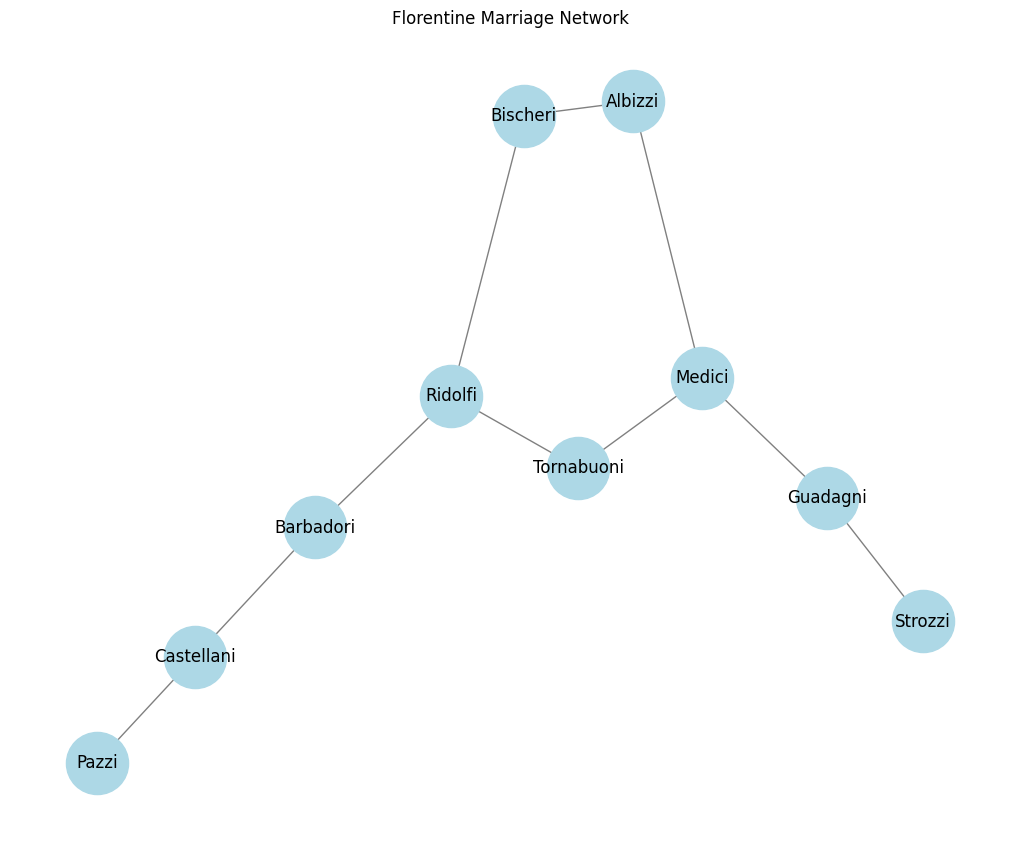

In [5]:

import networkx as nx
import matplotlib.pyplot as plt
from py2neo import Graph

graph_db = Graph("neo4j+s://20420c72.databases.neo4j.io", auth=("neo4j", "cyBNYP2F-nbLQOIukffU5lvU34C9pHcxaEPII1PTt-w"))

def load_florentine_data():
    families = [
        "Medici", "Strozzi", "Guadagni", "Albizzi", "Bischeri", "Pazzi", "Castellani", "Barbadori", "Ridolfi", "Tornabuoni"
    ]
    edges = [
        ("Medici", "Guadagni"), ("Medici", "Albizzi"), ("Medici", "Tornabuoni"),
        ("Strozzi", "Guadagni"), ("Albizzi", "Bischeri"), ("Bischeri", "Ridolfi"),
        ("Ridolfi", "Tornabuoni"), ("Castellani", "Barbadori"), ("Barbadori", "Ridolfi"),
        ("Pazzi", "Castellani")
    ]

    graph_db.run("MATCH (n) DETACH DELETE n")

    for family in families:
        graph_db.run("CREATE (:Family {name: $name})", name=family)

    for start, end in edges:
        graph_db.run(
            "MATCH (a:Family {name: $start}), (b:Family {name: $end}) "
            "CREATE (a)-[:MARRIED]->(b)",
            start=start, end=end
        )

def calculate_centrality():
    G = nx.Graph()
    nodes = graph_db.run("MATCH (n:Family) RETURN n.name AS name").data()
    edges = graph_db.run("MATCH (a:Family)-[:MARRIED]->(b:Family) RETURN a.name AS source, b.name AS target").data()

    for node in nodes:
        G.add_node(node['name'])

    for edge in edges:
        G.add_edge(edge['source'], edge['target'])

    degree_centrality = nx.degree_centrality(G)
    closeness_centrality = nx.closeness_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G)
    eigenvector_centrality = nx.eigenvector_centrality(G)
    pagerank = nx.pagerank(G)

    centralities = {
        "Degree Centrality": degree_centrality,
        "Closeness Centrality": closeness_centrality,
        "Betweenness Centrality": betweenness_centrality,
        "Eigenvector Centrality": eigenvector_centrality,
        "PageRank": pagerank
    }

    for measure, values in centralities.items():
        print(f"\n{measure}:")
        for node, score in values.items():
            print(f"{node}: {score:.4f}")

    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=2000, edge_color='gray')
    plt.title("Florentine Marriage Network")
    plt.show()

if __name__ == "__main__":
    print("Loading data into Neo4j...")
    load_florentine_data()

    print("\nCalculating centrality measures...")
    calculate_centrality()
